# Dimensionality Reduction

## The Curse of Dimensionality

## Main approaches for Dimensionality Reduction

### Projection

In below we can see a 3D dataset represented by
circles.

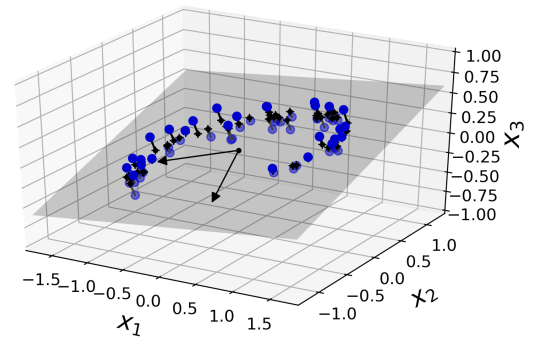

Notice that all training instances lie close to a plane: this is a lower-
dimensional (2D) subspace of the high-dimensional (3D) space. If we
project every training instance perpendicularly onto this subspace (as
represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown in below figure Ta-da! We have just reduced
the dataset’s dimensionality from 3D to 2D. Note that the axes correspond
to new features z1 and z2 (the coordinates of the projections on the plane).

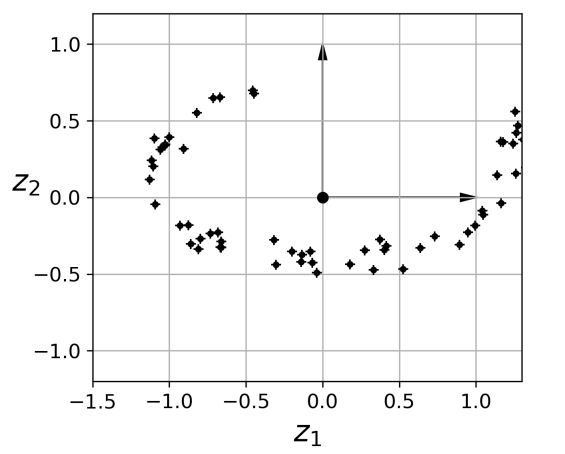

However, projection is not always the best approach to dimensionality
reduction. In many cases the subspace may twist and turn, such as in the
famous *Swiss roll* toy dataset represented in below figure.

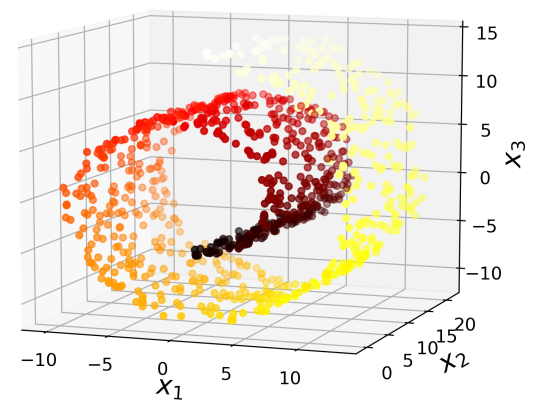

Simply projecting onto a plane (e.g., by dropping $x_3$) would squash
different layers of the Swiss roll together, as shown on the left side of
below figure. What we really want is to unroll the Swiss roll to obtain the
2D dataset on the right side of below figure.

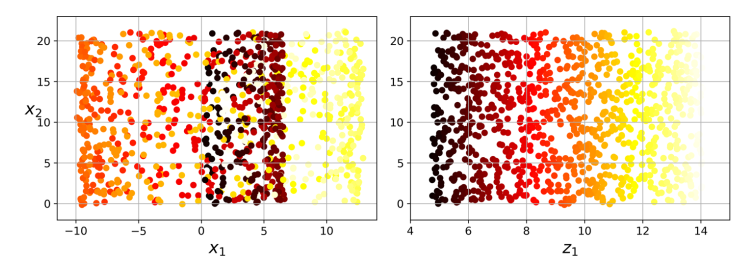

### Manifold Learning

The manifold assumption is often accompanied by another implicit
assumption: that the task at hand (e.g., classification or regression) will be
simpler if expressed in the lower-dimensional space of the manifold. For
example, in the top row of below figure the Swiss roll is split into two
classes: in the 3D space (on the left), the decision boundary would be
fairly complex, but in the 2D unrolled manifold space (on the right), the
decision boundary is a straight line.

However, this implicit assumption does not always hold. For example, in
the bottom row of below figure, the decision boundary is located at x1 = 5.
This decision boundary looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a
collection of four independent line segments).

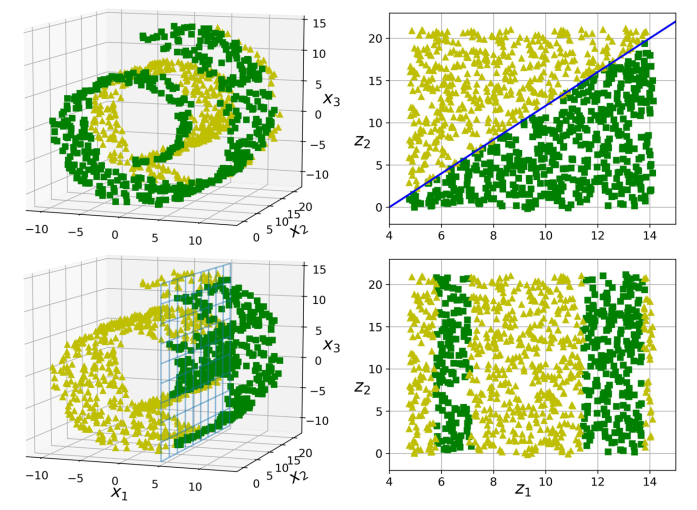

In short, reducing the dimensionality of your training set before training a
model will usually speed up training, but it may not always lead to a better
or simpler solution; it all depends on the dataset.

## PCA

### Preserving Variance

For example, a simple 2D dataset is represented on the left in below figure, along with three
different axes (i.e., 1D hyperplanes). On the right is the result of the projection of the dataset onto each of these axes. As you can see, the projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves very little variance and the projection onto the dashed line preserves an intermediate amount of variance.

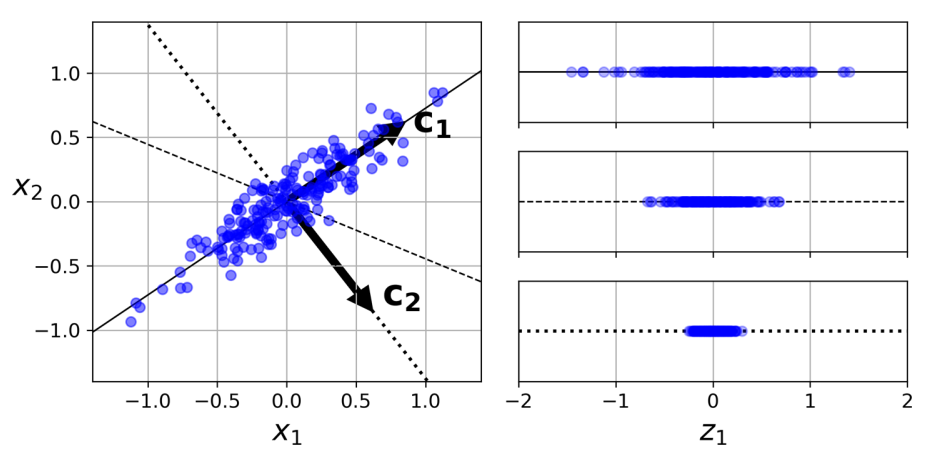


### Principal Components

PCA identifies the axis that accounts for the largest amount of variance in
the training set. In above figure, it is the solid line. It also finds a second
axis, orthogonal to the first one, that accounts for the largest amount of
remaining variance. In this 2D example there is no choice: it is the dotted
line. If it were a higher-dimensional dataset, PCA would also find a third
axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as
many axes as the number of dimensions in the dataset.

In above figure 8-7, the first PC is the axis on which vector **`c1`** lies, and the second
PC is the axis on which vector **`c2`** lies.

The following Python code uses NumPy’s `svd()` function to obtain all the
principal components of the training set, then extracts the two unit vectors
that define the first two PCs:

In [5]:
# Let's first build simple 3D dataset
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.rand(m) / 2
X[:,1] = np.sin(angles) * 0.7 + noise * np.random.rand(m) / 2
X[:,2] = X[:,0] * w1 + X[:,1] * w2 + noise * np.random.randn(m)

In [9]:
X_centered = X - X.mean(axis=0)
U, s, vt = np.linalg.svd(X_centered)
c1 = vt[:,0]
c2 = vt[:,1]

**Warning:**

PCA assumes that the dataset is centered around the origin. As we will see, Scikit-
Learn’s PCA classes take care of centering the data for us. If we implement PCA
ourself (as in the preceding example), or if we use other libraries, we have to center the data first.

### Projecting down to *d* dimensions

The following Python code projects the training set onto the plane defined
by the first two principal components:

In [15]:
W2 = vt.T[:, :2] # all rows and first two columns
X2D = X_centered.dot(W2)

### Using Scikit Learn

Scikit-Learn’s PCA class uses SVD decomposition to implement PCA, just
like we did earlier. The following code applies PCA to
reduce the dimensionality of the dataset down to two dimensions (note
that it automatically takes care of centering the data):

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its `components_` attribute
holds the transpose of $W_\textit{d}$ (e.g., the unit vector that defines the first
principal component is equal to `pca.components_.T[:, 0]`).

In [19]:
X2D[:5]

array([[ 1.24095394,  0.4389542 ],
       [-0.0599016 , -0.40965857],
       [ 1.24842983,  0.4238199 ],
       [ 0.81463103, -0.25993135],
       [ 0.71509461, -0.29631435]])

### Explained variance ratio

Another useful piece of information is the *explained variance ratio* of each principal component, available via the `explained_variance_ratio_` variable. The ratio indicates the proportion of dataset's varaiance that lie along each principal component.

In [20]:
pca.explained_variance_ratio_

array([0.84958377, 0.1423202 ])

This output tells us that 84.9% of the dataset’s variance lies along the
first PC, and 14.2% lies along the second PC. This leaves less than 0.9%
for the third PC, so it is reasonable to assume that the third PC probably
carries little information. 

### Choosing the right number of dimensions:

The following code performs PCA without reducing dimensionality, then
computes the minimum number of dimensions required to preserve 95%
of the training set’s variance:

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [23]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [30]:
d

154

We could then set `n_components=d` and run PCA again. But there is a
much better option: instead of specifying the number of principal
components we want to preserve, we can set `n_components` to be a float
between 0.0 and 1.0, indicating the ratio of variance we wish to preserve:

In [31]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [32]:
pca.n_components_

154

In [36]:
np.sum(pca.explained_variance_ratio_)

0.9504127888294238

Yet another option is to plot the explained variance as a function of the
number of dimensions (simply plot `cumsum`; see below graph). There will
usually be an elbow in the curve, where the explained variance stops growing fast. In this case, you can see that reducing the dimensionality
down to about 100 dimensions wouldn’t lose too much explained variance.

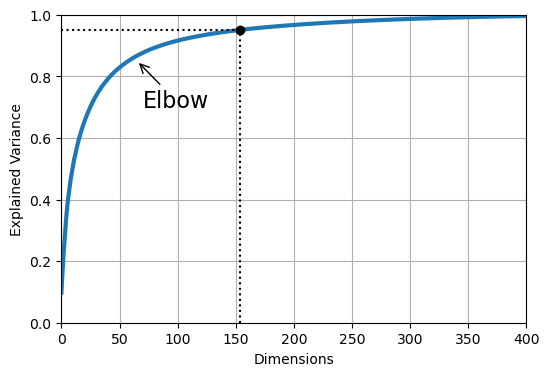

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0 ,1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### PCA for Compression

After dimensionality reduction, the training set will takes up much less space. For example as shown above, applying PCA to MNIST dataset while preserving 95% variance, we found out that each instance have just 154 features, instead of original 784 features. So while most of the variance is preserved, the dataset is now less than 20% of its original size!. This is a reasonable  compression ratio, as we can see how this size reduction can speed up a classification algorithm (such as SVM classifier) tremendously. 

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformations of the PCA projection. This won't give us back the original data, since the projection lost a bit of information (within the 5% of the variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the recontructed data (compressed and decompressed) is called *reconstruction error*.

The following code compresses the MNIST dataset down to 154
dimensions, then uses the inverse_transform() method to decompress it
back to 784 dimensions:

In [42]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [46]:
import matplotlib as mpl
import numpy as np

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

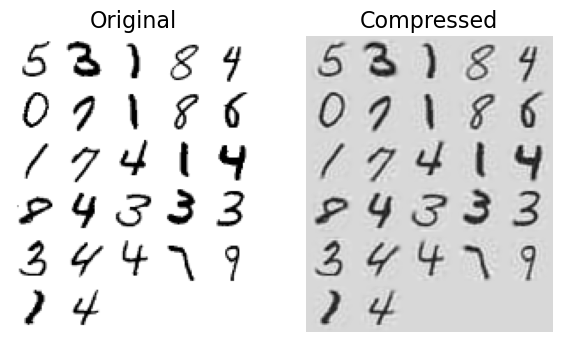

In [47]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100]) #The :: syntax indicates that we want to select elements from the entire array. The 2100 specifies the step size, which means we want to select elements at intervals of 2100.
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

Above figure shows a few digits from the original training set (on the left),
and the corresponding digits after compression and decompression. We
can see that there is a slight image quality loss, but the digits are still
mostly intact. 

In [53]:
X_reduced_pca = X_reduced

### Randomzied PCA

If we set the `svd_solver` hyperparameter to "randomized", Scikit-Learn
uses a stochastic algorithm called *Randomized* PCA that quickly finds an
approximation of the first *d* principal components. Its computational
complexity is $O(m* d^2) + O(d^3)$, instead of $O(m × n^2) + O(n^3)$ for the full
SVD approach, so it is dramatically faster than full SVD when d is much
smaller than n:

In [54]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

By default, `svd_solver` is actually set to `"auto"`: Scikit-Learn
automatically uses the randomized PCA algorithm if *m* or *n* is greater than
500 and *d* is less than 80% of *m* or n, or else it uses the full SVD approach.
If we want to force Scikit-Learn to use full SVD, we can set the
`svd_solver` hyperparameter to `"full"`.

### Incremental PCA

One problem with the preceding implementations of PCA is that they
require the whole training set to fit in memory in order for the algorithm
to run. Fortunately, *Incremental* PCA (IPCA) algorithms have been
developed. They allow you to split the training set into mini-batches and
feed an IPCA algorithm one mini-batch at a time. This is useful for large
training sets and for applying PCA online (i.e., on the fly, as new instances
arrive).



In [55]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Alternatively, you we use NumPy’s `memmap` class, which allows us to
manipulate a large array stored in a binary file on disk as if it were
entirely in memory; the class loads only the data it needs in memory, when
it needs it. Since the `IncrementalPCA` class uses only a small part of the
array at any given time, the memory usage remains under control. This
makes it possible to call the usual `fit()` method, as we can see in the
following code:

In [56]:
# Let's create the memmap() structure and copy the MNIST data into it. This would typically be done by a first program:

filename="my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode="write", shape=(m, n))
X_mm[:] = X_train

In [57]:
# Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

del X_mm

In [58]:
X_mm = np.memmap(filename, dtype='float32', mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=560, n_components=154)

## Kernel PCA

In Chapter 5 we learned about the kernel trick, a mathematical technique that
implicitly maps instances into a very high-dimensional space (called the
*feature space*), enabling nonlinear classification and regression with
Support Vector Machines. Recall that a linear decision boundary in the
high-dimensional feature space corresponds to a complex nonlinear
decision boundary in the *original space*.

It turns out that the same trick can be applied to PCA, making it possible
to perform complex nonlinear projections for dimensionality reduction.
This is called `Kernel PCA (kPCA)`. It is often good at preserving clusters
of instances after projection, or sometimes even unrolling datasets that lie
close to a twisted manifold.

The following code uses Scikit-Learn’s `KernelPCA` class to perform kPCA
with an RBF kernel:

In [59]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [60]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

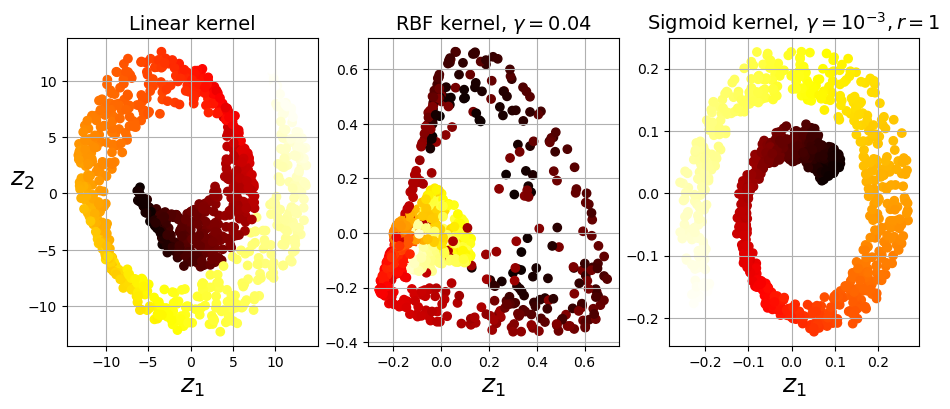

In [61]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()


Above graph shows the Swiss roll, reduced to two dimensions using a linear
kernel (equivalent to simply using the PCA class), an RBF kernel, and a
sigmoid kernel.

### Selecting Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obivous performance measure to help us select the best kernel and hyperparameter values. That said, dimensionality reduction is often a preparation step for supervised learning task (e.g., classification), so we can use grid search to select the kernel and hyperparameters that lead to best performance on that task.

The following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applyling LogisticRegression for classification. Then it used `GridSearchCV` to find best kernel and gamma for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03,0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [64]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error. Note that reconstruction is not as easy as with linear PCA. Here's why: 

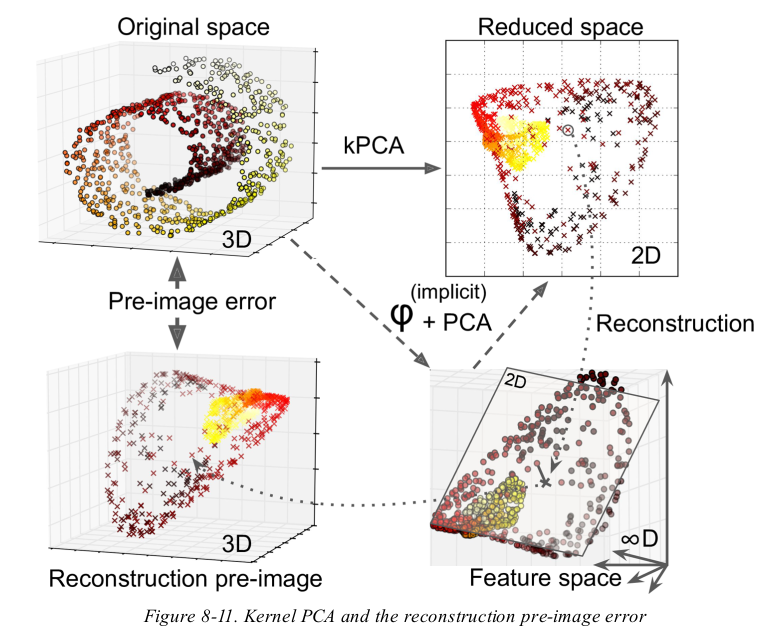


Above figure shows the original Swiss roll 3D dataset (top left) adn the resulting 2D dataset after kPCA applied using RBF kernel (top right). Thanks to kernel trick, this transformation is equivalent to using *feature map* $\phi$ to map the training set to an infinite-dimensional training set (bottom right), then projecting the transformed training dataset down to 2D using linear PCA. 

Notice that if we could invert the linear PCA for a given instance in the reduced space, the reconstructed point would lie in feature space, not in original space (e.g., like the one represented by an X in the diagram). Since the feature space is infinite-dimensional, we cannot compute the constructed point, and therefore we connot compute the true reconstruction error. Fortunately it is possible to find a point in the original space that would map close to the reconstructed point. This point is called the reconstruction *pre-image*. Once we have this pre-image, we can measure its squared distance to the original distance. We can then select the kernel and hyperparameters that minimize the reconstruction pre-image eror.

How to perform this reconstruction? 

One solution is to train a supervised regression model, with projected instances as the training set and the original instances as the targets. Scikit-Learn will do this `automatically` if we set `fit_inverse_transform=True`.

In [68]:
rbf_pca = KernelPCA(n_components=2, kernel=grid_search.best_params_["kpca__kernel"], gamma=grid_search.best_params_["kpca__gamma"], fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [69]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.795235787253354

**NOTE:**

By default, `fit_inverse_transform=False` and KernelPCA has no
`inverse_transform()` method. This method only gets created when we set
`fit_inverse_transform=True`.

## LLE

The following code uses Scikit-Learn’s `LocallyLinearEmbedding` class to
unroll the Swiss roll:

In [77]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [78]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

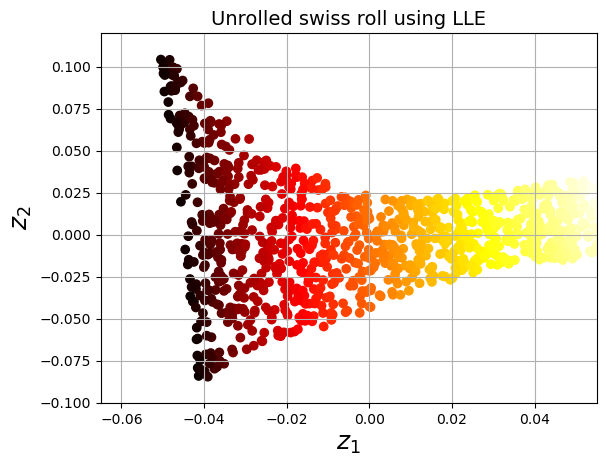

In [79]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

The resulting 2D dataset is shown in above figure. As we can see, the
Swiss roll is completely unrolled, and the distances between instances are
locally well preserved. However, distances are not preserved on a larger
scale: the left part of the unrolled Swiss roll is stretched, while the right
part is squeezed. Nevertheless, LLE did a pretty good job at modeling the
manifold.